This notebook aims to show how we cluster the lightning data and save into masks.

In [1]:
import geopy
import numpy as np
import pandas as pd
import xarray as xr
from glob import glob
import proplot as pplt
from satpy import Scene
import metpy.calc as mpcalc
from metpy.units import units
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from geopy.distance import geodesic
from pandarallel import pandarallel
from scipy.interpolate import interpn


In [2]:
# pick the case for test
case = '2019-06-27'

if case == '2019-06-27':
    # Plot region for 20190627T18
    lon_min = 95; lon_max = 145
    lat_min = 72; lat_max = 88

    f_era5 = '../data/era5/era5_201906.nc'
    f_tropomi = glob('../data/tropomi/201906/S5P_PAL__L2__NO2____20190627T18*.nc')
    f_lightning = '../data/gld360/density/201906/20190627.csv'
    lightning_subset = ['2019-06-27 10:00', '2019-06-27 19:30']

elif case == '2019-08-11':
    # Plot region for 20190811T00
    lon_min = 95; lon_max = 145
    lat_min = 82; lat_max = 88

    f_era5 = '../data/era5/era5_201908.nc'
    f_tropomi = glob('../data/tropomi/201908/S5P_PAL__L2__NO2____20190811T00*.nc')
    f_lightning = '../data/gld360/density/201908/20190810.csv'
    lightning_subset = ['2019-08-10 20:00', '2019-08-11 00:00']


## Read TROPOMI data

In [3]:
# read tropomi NO2 L2 data using satpy
scn = Scene(f_tropomi, reader='tropomi_l2')
vnames = ['time_utc', 'nitrogendioxide_tropospheric_column']
scn.load(vnames)

# get the mean overpass time for the Arctic
t_overpass = pd.to_datetime(scn['time_utc'].where(scn['nitrogendioxide_tropospheric_column'].latitude.mean('x') >= 70, drop=True)).mean()

Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/surface_pressure
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/surface_pressure


## Read lightning data

In [4]:
df = pd.read_csv(f_lightning)

# pick the interesting region and time
df = df[(df['latitude']>70)  & (df['latitude']<88)]

# get lightning dots during the several hours before the mean overpass time
df['timestamp'] =  pd.to_datetime(df['timestamp'], utc=True)
delta = df['timestamp'] - t_overpass
df['delta'] = delta.dt.total_seconds()/60

df = df.set_index('timestamp')
df = df[lightning_subset[0]:lightning_subset[1]]

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

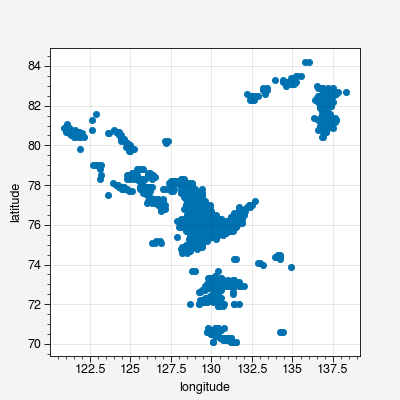

In [5]:
df.plot.scatter(x='longitude', y='latitude')

## Cluster the observed lightning by 40 km radius

In [6]:
def get_large_hull(hulls, stretchCoef=1.5):
    '''Get a larger hull in case some fires are nearby'''
    large_hull = []
    for hull in hulls:
        stretchCoef = stretchCoef
        pointsStretched = hull.points[hull.vertices]*stretchCoef # test
        #pointsStretched = bufferPoints(hull.points, stretchCoef, n=100) # true
        # ring = LinearRing(list(zip(pointsStretched[:, 1], pointsStretched[:, 0])))
        large_hull.append(pointsStretched[:, [1,0]])

    return large_hull

def get_cluster(df_lightning):
    '''Get the cluster of lightning points
    
    Ref: https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/

    '''
    coords = df_lightning[['latitude', 'longitude']].values
    kms_per_radian = 6371.0088

    # search for 40km around each lightning dots
    epsilon = 40/kms_per_radian
    db = DBSCAN(eps=epsilon, min_samples=2, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_

    df_cluster = pd.DataFrame({'time': df_lightning['timestamp'].values,
                               'longitude': df_lightning['longitude'].values,
                               'latitude': df_lightning['latitude'].values,
                               'delta': df_lightning['delta'].values,
                               'label': cluster_labels})

    # drop noise data (-1)
    df_cluster = df_cluster[df_cluster.label != -1] 

    # more than 20 points
    v = df_cluster.label.value_counts()
    df_cluster = df_cluster[df_cluster.label.isin(v.index[v.gt(20)])]
    cluster_labels = list(set(df_cluster['label']))
    # num_clusters = len(cluster_labels)

    hulls = []

    for label in cluster_labels:
        dfq = df_cluster[df_cluster['label']==label]
        Y = np.array(dfq[['longitude', 'latitude']])
        hull = ConvexHull(Y)
        hulls.append(hull)

    large_hulls = get_large_hull(hulls)

    return df_cluster, cluster_labels, large_hulls


In [7]:
df_cluster, cluster_labels, hulls = get_cluster(df.reset_index())

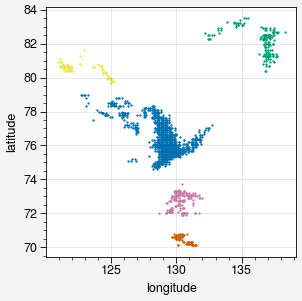

In [8]:
fig, axs = pplt.subplots()

for n, grp in df_cluster.groupby('label'):
    axs.scatter(x='longitude', y='latitude', data=grp, label=n, s=1)

## Predict the transported lightning air using era5 data

Read the monthly ERA5 wind data first.

In [9]:
ds_era5 = xr.open_dataset(f_era5)
ds_era5 = ds_era5.loc[{'latitude':sorted(ds_era5.coords['latitude'])}]

Then, predict the transported lightning air step by step.

In [10]:
def get_delta_time(begin_time, end_time):
    # because the ds is hourly data, we need to create the hourly time step
    times = np.concatenate(([begin_time.to_pydatetime().replace(tzinfo=None)],
                            pd.date_range(begin_time.ceil('h').replace(tzinfo=None),
                            end_time.floor('h').replace(tzinfo=None), freq='H').to_pydatetime(),
                            [end_time.replace(tzinfo=None).to_pydatetime()]
                            ))

    # calculate the time delta (seconds)
    time_step = [t.total_seconds() for t in np.diff(times)]

    return time_step


def calc_wind(row, coords, u, v, time_pred, lon_column, lat_column):
    '''Calculate the wspd and wdir'''
    # interpolate the u and v fields
    interp_points = [xr.DataArray(time_pred).astype('float').values, row[lat_column], row[lon_column]]
    u_interp = interpn(coords, u, interp_points)
    v_interp = interpn(coords, v, interp_points)

    # wind speed (m/s)
    wspd = mpcalc.wind_speed(u_interp * units.meters / units.second,
                             v_interp * units.meters / units.second).magnitude

    # wind direction (degree)
    wdir = mpcalc.wind_direction(u_interp * units.meters / units.second,
                                 v_interp * units.meters / units.second,
                                 convention='to').magnitude

    return wspd, wdir


def predict_loc(row, level, coords, u, v):
    '''Predict the location using wind data'''
    # set the column names for saving predicted location
    lon_column = f'longitude_pred_{level}'
    lat_column = f'latitude_pred_{level}'

    # copy the initial location
    row[lon_column] = row['longitude']
    row[lat_column] = row['latitude']
    time_pred = row['time']

    for delta in row['time_step']:
        # interpolate the wind info from era5
        wspd, wdir = calc_wind(row, coords, u, v, time_pred, lon_column, lat_column)

        # predict the location at next time
        # https://stackoverflow.com/a/40645383/7347925
        # validation website: https://www.fcc.gov/media/radio/find-terminal-coordinates
        # this method has issue with pandarallel
        dest = geodesic(kilometers=(wspd*delta/1e3))\
            .destination(geopy.Point(row[lat_column], row[lon_column]), wdir)
        lat2 = dest[0]
        lon2 = dest[1]

        # save the predicted location
        row[lon_column] = lon2
        row[lat_column] = lat2

        # update time to the next step
        time_pred = time_pred + pd.Timedelta(seconds=delta)

    return row

def pred_cluster(df_cluster, t_overpass, ds_era5, wind_levels):
    '''Predict the location of transported lighting clusters
    1) Get the interped wind direction and wind speed at each lightning location from hourly ERA5 data
    2) Predict the location of lightning air at the TROPOMI overpass time by the wind info
    Note that the source of high NO2 could originate frome different pressure levels.
    So, we checked chose 700 hPa ~ 300 hPa for prediction.
    '''
    pandarallel.initialize(nb_workers=3, progress_bar=True)

    # convert DataArray to numpy array for scipy.interpolate.interpn
    #   the order should be time, lat, and lon
    #   because the dim of era5 variables is (time, level, latitude, longitude)
    coords = [ds_era5.time.astype(float).values, ds_era5.latitude.values, ds_era5.longitude.values]

    # get time steps  between flash time and TROPOMI overpass time
    df_cluster['time_step'] = df_cluster.apply(lambda row: get_delta_time(row['time'], t_overpass), axis=1)

    for level in wind_levels:
        # get the wind at the pressure level
        u = ds_era5['u'].sel(level=level).values
        v = ds_era5['v'].sel(level=level).values

        # using the wind info to predict the location at the TROPOMI overpass time
        df_cluster = df_cluster.parallel_apply(lambda row: predict_loc(row, level, coords, u, v), axis=1)

    # remove useless columns
    df_cluster.drop(['time_step'], axis=1, inplace=True)

    return df_cluster

In [11]:
wind_levels = np.arange(700, 100, -200)  # pressure levels used to calculate the location of transported LNO2 air parcel

df_cluster_pred = pred_cluster(df_cluster, t_overpass, ds_era5, wind_levels)

INFO: Pandarallel will run on 3 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/tmp/ipykernel_44182/833946528.py:82: UserWarning: Discarding nonzero nanoseconds in conversion
  df_cluster['time_step'] = df_cluster.apply(lambda row: get_delta_time(row['time'], t_overpass), axis=1)


Here's the comparison between observed lightning and the transported lightning air at the TROPOMI overpass time.

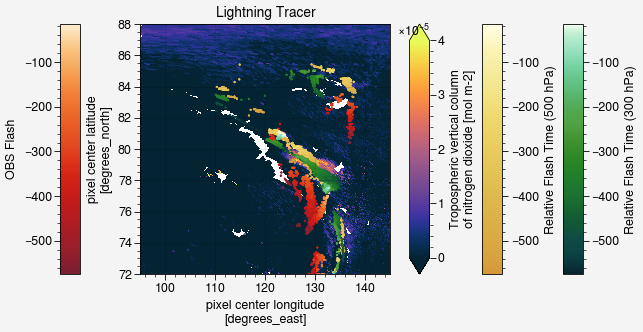

In [12]:
fig, axs = pplt.subplots()

lon = scn['nitrogendioxide_tropospheric_column'].coords['longitude']
lat = scn['nitrogendioxide_tropospheric_column'].coords['latitude']

mask = (lon>lon_min) & (lon<lon_max) & (lat>lat_min) & (lat<lat_max)
scn['nitrogendioxide_tropospheric_column'].where(mask, drop=True).plot(x='longitude', y='latitude',
cmap='Thermal', vmin=0, vmax=4e-5, discrete=False)

s = axs.scatter(df_cluster_pred['longitude'], df_cluster_pred['latitude'],
            marker="$\u25EF$", cmap='Reds2_r',
            c=df_cluster_pred['delta'], s=1)
axs.colorbar(s, loc='l', label=f'OBS Flash')

# s = axs.scatter(df_cluster_pred['longitude_pred_700'], df_cluster_pred['latitude_pred_700'],
#             marker="$\u25EF$", cmap='Blues2_r',
#             c=df_cluster_pred['delta'], s=1)
# axs.colorbar(s, loc='r', label=f'Relative Flash Time (700 hPa)')

s = axs.scatter(df_cluster_pred['longitude_pred_500'], df_cluster_pred['latitude_pred_500'],
            marker="$\u25EF$", cmap='Yellows2_r',
            c=df_cluster_pred['delta'], s=1)
axs.colorbar(s, loc='r', label=f'Relative Flash Time (500 hPa)')

s = axs.scatter(df_cluster_pred['longitude_pred_300'], df_cluster_pred['latitude_pred_300'],
            marker="$\u25EF$", cmap='Greens2_r',
            c=df_cluster_pred['delta'], s=1)
axs.colorbar(s, loc='r', label=f'Relative Flash Time (300 hPa)')

axs.format(xlim=(lon_min,lon_max), ylim=(lat_min,lat_max), title='Lightning Tracer')

## Cluster transported lightning air and save into masks

In [13]:
def in_hull(p, hull):
    """ 
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed

    https://stackoverflow.com/a/16898636/7347925
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

In [14]:
def concat_pred(ds):
    '''Concatenate predicted lon and lat by pressure level'''
    # get the DataArray names of predicted lon and lat
    lon_names = [var for var in ds.data_vars if 'longitude_pred' in var]
    lat_names = [var for var in ds.data_vars if 'latitude_pred' in var]
    levels = [int(name.split('_')[-1]) for name in lon_names]

    # concatenate into one array
    ds['longitude_pred'] = ds[lon_names].to_array(dim='lon_level', name='longitude_pred').assign_coords(lon_level=levels).rename({'lon_level':'level'})
    ds['latitude_pred'] = ds[lat_names].to_array(dim='lat_level', name='longitude_pred').assign_coords(lat_level=levels).rename({'lat_level':'level'})
    ds.coords['level'].attrs['units'] = 'hPa'

    # add description and units
    ds['longitude_pred'].attrs['description'] = 'Longitude of lightning at different pressure levels predicted by ERA5 data'
    ds['latitude_pred'].attrs['description'] = 'Latitude of lightning at different pressure levels predicted by ERA5 data'

    # drop useless variables
    ds = ds.drop_vars(lon_names+lat_names)

    return ds


In [15]:
def convert_cluster(scn, df, lightning_mask, kind='clean'):
    '''Convert the lightning cluster DataFrame to Dataset which has the same shape of NO2'''
    # rename the label
    df = df.rename(columns={'label':'lightning_label'})
    # set label as index which is the coordinate of xarray Dataset
    df.set_index(['lightning_label'], inplace=True)
    # convert to Dataset
    ds = concat_pred(df.to_xarray())

    # get the pixel center points
    pixel_points = np.vstack((scn['nitrogendioxide_tropospheric_column'].longitude.stack(z=('x', 'y')),
                              scn['nitrogendioxide_tropospheric_column'].latitude.stack(z=('x', 'y')))
                              ).T 

    labels = list(set(ds.lightning_label.values))
    fig, axs = pplt.subplots(nrows=2, ncols=3)

    for index, label in enumerate(labels):
        # iterate each label and update the mask
        dfq = ds.sel(lightning_label=label)
        lon_lat = dfq[['longitude_pred', 'latitude_pred']].stack(all=("level", "lightning_label"))
        lightning_points = lon_lat.to_array().transpose('all', ...)
        # hull = ConvexHull(lightning_points)

        mask = in_hull(pixel_points, lightning_points).reshape(scn['nitrogendioxide_tropospheric_column'].shape, order='F')

        # get the overplapped label
        overlapped_label = np.delete(np.unique(lightning_mask.where(xr.DataArray(mask, dims=['y', 'x']), 0)), 0)

        if len(overlapped_label) == 0:
            if kind == 'clean':
                # clean lightning label: 1, 2, ....
                lightning_mask = xr.where(mask, index+1, lightning_mask)
            elif kind == 'polluted':
                # polluted lightning label: -1, -2, ....
                lightning_mask = xr.where(mask, -index-1, lightning_mask)
        elif len(overlapped_label) == 1:
            # set to the only overlapped value
            if kind == 'clean':
                lightning_mask = xr.where(mask, overlapped_label[0], lightning_mask)
            elif kind == 'polluted':
                lightning_mask = xr.where(mask, overlapped_label[0], lightning_mask)
        else:
            # get the minimum label
            min_label = overlapped_label.min()
            # set the mask where lightning happens to minimum label
            lightning_mask = xr.where(mask, min_label, lightning_mask)
            # update mask with the rest labels
            for rest_label in np.delete(overlapped_label, np.where(overlapped_label == min_label)):
                lightning_mask = lightning_mask.where(lightning_mask!=rest_label, min_label)

        lightning_mask.plot(ax=axs[index], x='longitude', y='latitude', add_colorbar=False)
        axs[index].format(title=f'Step {index}')
    axs.format(xlim=(lon_min, lon_max), ylim=(lat_min, lat_max))

    return ds, lightning_mask.rename('lightning_mask')

The procedure of clustering is shown below.

For `20190811T00`, just one step ...  `20190627T18` is the suitable show case.

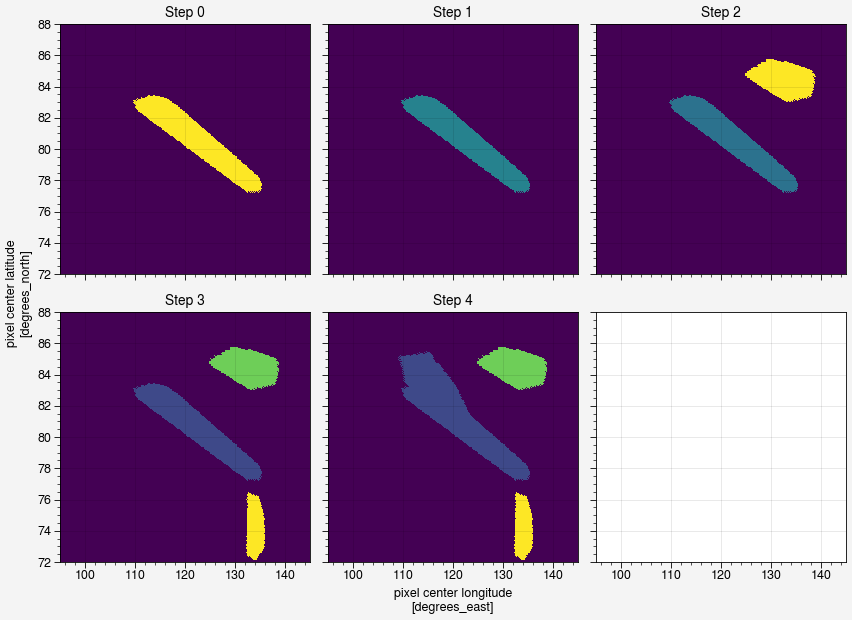

In [16]:
lightning_mask = xr.full_like(scn['nitrogendioxide_tropospheric_column'], 0, dtype=int).load().copy()
clean_cluster, clean_lightning_mask = convert_cluster(scn, df_cluster_pred, lightning_mask, 'clean')